In [4]:
import os
import os.path

#we require numpy, opencv, and matplotlib
import numpy as np
import cv2
import matplotlib

#this disables GUI windows from popping up
# matplotlib.use('Agg')
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
#set working directory to location of script:
print (os.getcwd())
# dname = '/home/opencv/heatmap'
# os.chdir(dname)


/home/opencv/Heatmap


**Helper functions**

In [6]:
def parse_line(line):

    # format of a line is space delineated in the following format
    #
    # image_file_path number_of_labels x1 y1 x2 y2 x3 y3 x4 y4 x1 y1 x2 y2 x3 y3 x4 y4 ... etc
    #
    # Note: We use 4 x,y coordinates to denote a detection label
    # since Orpix logo detection outputs a quadrilateral as opposed to a rectangle
    toks = line.split(' ')

    frame_path = toks[0]
    label_count = int(toks[1])

    # getting points only, casting to int
    pts = toks[2:]
    pts = [int(x) for x in pts]

    labels = []
    for i in range(label_count):

        # get the 8 points for the current label
        label_pts = pts[i*8:i*8+8]

        # reshape to array of 4 tuples
        pt_pairs = []
        for ptind in range(0, 8, 2):
            pt_pairs.append([label_pts[ptind], label_pts[ptind+1]])

        # add this label to the list of labels we return
        pt_pairs = np.array(pt_pairs)
        labels.append(pt_pairs)

    return frame_path, np.array(labels)

# help function to highlight the labels in each input frame
# by interpolating the background with white


def highlight_labels(img, labels, maskimg=None):

    # create a copy of the image so we can draw on it
    imgcpy = img.copy()

    # draw a quadrilateral for each label in red
    cv2.polylines(imgcpy, labels, True, (0, 0, 255), thickness=2)

    # a mask needs to be created from the labels so we can properly highlight.
    # if the mask isn't passed in, we create it
    if type(maskimg) == type(None):
        maskimg = np.zeros(imgcpy.shape, dtype=np.float)
        for label in labels:
            # this sets all pixels inside the label to 1
            cv2.fillConvexPoly(maskimg, label, (1))

    # create a rgb version of the mask by setting each channel to the mask we created
    maskimg = (maskimg > 0).astype(np.uint8)
    maskrgb = np.zeros(imgcpy.shape, np.uint8)
    maskrgb[:, :, 0] = maskimg
    maskrgb[:, :, 1] = maskimg
    maskrgb[:, :, 2] = maskimg

    # interpolate image with white using a weighted sum
    bgimg = .5*255*np.ones(imgcpy.shape, np.float) + .5*imgcpy.astype(np.float)
    # mask out the background
    bgimg = (1-maskrgb)*bgimg
    # cast to uint8 image
    bgimg = np.round(bgimg).astype(np.uint8)

    # get foreground unchanged
    fgimg = maskrgb*imgcpy

    # add white tinted background with unchanged foreground
    imgcpy = bgimg + fgimg.astype(np.uint8)

    return imgcpy

**Create the heatmap**

processing visa_frames/8293.jpg
processing visa_frames/57.jpg
processing visa_frames/58.jpg
processing visa_frames/59.jpg
processing visa_frames/60.jpg
processing visa_frames/61.jpg
processing visa_frames/128.jpg
processing visa_frames/129.jpg
processing visa_frames/130.jpg
processing visa_frames/131.jpg
processing visa_frames/132.jpg
processing visa_frames/133.jpg
processing visa_frames/134.jpg
processing visa_frames/135.jpg
processing visa_frames/136.jpg
processing visa_frames/195.jpg
processing visa_frames/196.jpg
processing visa_frames/197.jpg
processing visa_frames/368.jpg
processing visa_frames/369.jpg
processing visa_frames/370.jpg
processing visa_frames/371.jpg
processing visa_frames/372.jpg
processing visa_frames/373.jpg
processing visa_frames/374.jpg
processing visa_frames/375.jpg
processing visa_frames/376.jpg
processing visa_frames/377.jpg
processing visa_frames/378.jpg
processing visa_frames/379.jpg
processing visa_frames/380.jpg
processing visa_frames/381.jpg
processing v

processing visa_frames/3087.jpg
processing visa_frames/3088.jpg
processing visa_frames/3089.jpg
processing visa_frames/3090.jpg
processing visa_frames/3091.jpg
processing visa_frames/3092.jpg
processing visa_frames/3093.jpg
processing visa_frames/3094.jpg
processing visa_frames/3095.jpg
processing visa_frames/3096.jpg
processing visa_frames/3097.jpg
processing visa_frames/3098.jpg
processing visa_frames/3099.jpg
processing visa_frames/3100.jpg
processing visa_frames/3101.jpg
processing visa_frames/3102.jpg
processing visa_frames/3103.jpg
processing visa_frames/3104.jpg
processing visa_frames/3115.jpg
processing visa_frames/3116.jpg
processing visa_frames/3117.jpg
processing visa_frames/3118.jpg
processing visa_frames/3119.jpg
processing visa_frames/3120.jpg
processing visa_frames/3121.jpg
processing visa_frames/3122.jpg
processing visa_frames/3123.jpg
processing visa_frames/3145.jpg
processing visa_frames/3146.jpg
processing visa_frames/3147.jpg
processing visa_frames/3148.jpg
processi

processing visa_frames/4852.jpg
processing visa_frames/4853.jpg
processing visa_frames/5154.jpg
processing visa_frames/5155.jpg
processing visa_frames/5156.jpg
processing visa_frames/5157.jpg
processing visa_frames/5158.jpg
processing visa_frames/5159.jpg
processing visa_frames/5160.jpg
processing visa_frames/5161.jpg
processing visa_frames/5162.jpg
processing visa_frames/5163.jpg
processing visa_frames/5164.jpg
processing visa_frames/5165.jpg
processing visa_frames/5166.jpg
processing visa_frames/5167.jpg
processing visa_frames/5168.jpg
processing visa_frames/5169.jpg
processing visa_frames/5170.jpg
processing visa_frames/5171.jpg
processing visa_frames/5172.jpg
processing visa_frames/5173.jpg
processing visa_frames/5174.jpg
processing visa_frames/5175.jpg
processing visa_frames/5176.jpg
processing visa_frames/5177.jpg
processing visa_frames/5178.jpg
processing visa_frames/5179.jpg
processing visa_frames/5180.jpg
processing visa_frames/5181.jpg
processing visa_frames/5182.jpg
processi

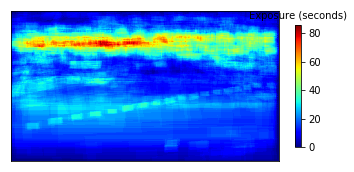

In [7]:
# keeps track of exposure time per pixel.  Accumulates for each image
accumulated_exposures = None

# frames were sampled at one second per frame.  If you sampled frames from a video at a different rate, change this value
# if you sampled frames at 10 frames per second, this value would be 0.1
seconds_per_frame = 1.0

# we open the labels file and will iterate through each line.
# each line contains a reference to the image and the corresponding polygon lables (4 points per label)
# each frame in the labels file was extracted from one video
with open('labels.txt') as f:
    lines = f.readlines()
    for line in lines:

        # parse the line using helper function
        frame_path, labels = parse_line(line)

        print ("processing {}".format(frame_path))

        # load the image
        frame = cv2.imread(frame_path)

        # this is where the highlighted images will go
        if not os.path.exists('output'):
            os.mkdir('output')

        # if the heatmap is None we create it with same size as frame, single channel
        if type(accumulated_exposures) == type(None):
            accumulated_exposures = np.zeros(
                (frame.shape[0], frame.shape[1]), dtype=np.float)

        # we create a mask where all pixels inside each label are set to number of seconds per frame that the video was sampled at
        # so as we accumulate the exposure heatmap counts, each pixel contained inside a label contributes the seconds_per_frame
        # to the overall accumulated exposure values
        maskimg = np.zeros(accumulated_exposures.shape, dtype=np.float)
        for label in labels:
            cv2.fillConvexPoly(maskimg, label, (seconds_per_frame))

        # highlight the labels on the image and save.
        # comment out the 2 lines below if you only want to compute the heatmap
        highlighted_image = highlight_labels(frame, labels, maskimg)
        cv2.imwrite('output/%s' %
                    os.path.basename(frame_path), highlighted_image)

        # accumulate the heatmap object exposure time
        accumulated_exposures = accumulated_exposures + maskimg

#
# create final heatmap using matplotlib
#

data = np.array(accumulated_exposures)
# create the figure
fig, axis = plt.subplots()
# set the colormap - there are many options for colormaps - see documentation
# we will use cm.jet
hm = axis.pcolor(data, cmap=plt.cm.jet)
# set axis ranges
axis.set(xlim=[0, data.shape[1]], ylim=[0, data.shape[0]], aspect=1)
# need to invert coordinate for images
axis.invert_yaxis()
# remove the ticks
axis.set_xticks([])
axis.set_yticks([])

# fit the colorbar to the height
shrink_scale = 1.0
aspect = data.shape[0]/float(data.shape[1])
if aspect < 1.0:
    shrink_scale = aspect
clb = plt.colorbar(hm, shrink=shrink_scale)
# set title
clb.ax.set_title('Exposure (seconds)', fontsize=10)

plt.show()

# saves image to same directory that the script is located in (our working directory)
# plt.savefig('heatmap.png', bbox_inches='tight')
# close objects
# plt.close('all')